In [1]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(1, os.path.abspath(os.pardir))
import CONFIG

%reload_ext autoreload
%autoreload 2

In [16]:
from IPython.display import Image

import pandas as pd
import numpy as np
import cv2
import os, re

import torch

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [5]:
INPUT_DIR = CONFIG.CFG.DATA.BASE
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))

In [6]:
def read_image_from_path(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def read_image_from_train_folder(image_id):
    path = os.path.join(INPUT_DIR, "train", f"{image_id}.jpg")
    return read_image_from_path(path)

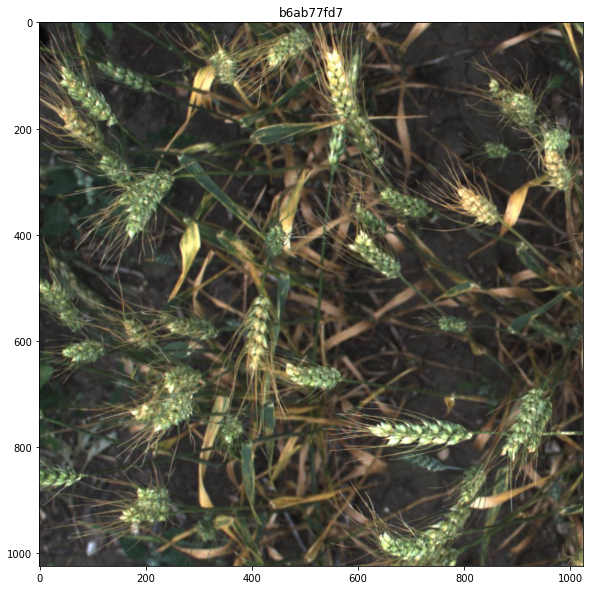

In [7]:
sample_image_id = "b6ab77fd7"
plt.imshow(read_image_from_train_folder(sample_image_id))
_ = plt.title(sample_image_id)

In [8]:
def parse_bbox_text(string_input):
    input_without_brackets = re.sub("\[|\]", "", string_input)
    input_as_list = np.array(input_without_brackets.split(","))
    return input_as_list.astype(np.float)

def xywh_to_x1y1x2y2(x,y,w,h):
    return np.array([x, y, x+w, y+h])

In [9]:
bbox_series = train_df.bbox.apply(parse_bbox_text)

xywh_df = pd.DataFrame(bbox_series.to_list(), columns=["x", "y", "w", "h"])

x2_df = pd.DataFrame(xywh_df.x + xywh_df.w, columns=["x2"])
y2_df = pd.DataFrame(xywh_df.y + xywh_df.h, columns=["y2"])

train_df = train_df.join([xywh_df, x2_df, y2_df])
train_df.head()

,image_id,width,height,bbox,source,x,y,w,h,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [10]:
def draw_boxes_on_image(boxes, image, color=(255,0,0)):
    for box in boxes:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 3
        )
    return image

Text(0.5, 1.0, '1e58125ec')

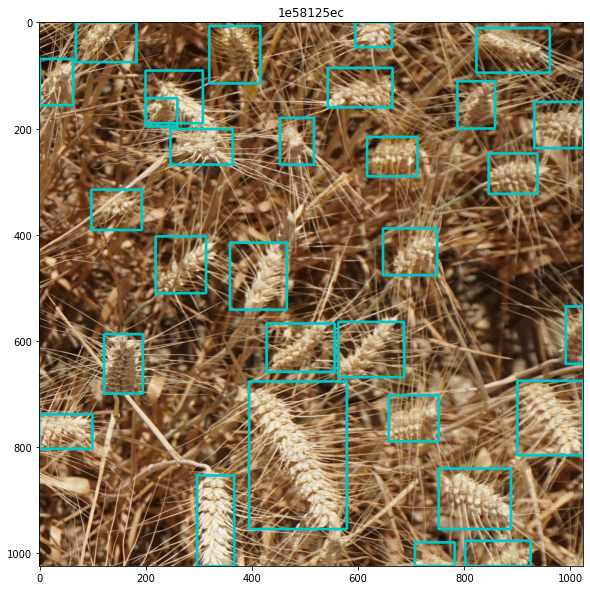

In [11]:
sample_image_id = train_df.image_id.sample().item()
sample_image = read_image_from_train_folder(sample_image_id)
sample_bounding_boxes = train_df[train_df.image_id == sample_image_id][["x", "y", "x2", "y2"]]

plt.imshow(draw_boxes_on_image(sample_bounding_boxes.to_numpy(), sample_image, color=(0, 200, 200)))
plt.title(sample_image_id)

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [18]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [19]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=2)

model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def move_batch_to_device(images, targets):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets


In [21]:
unique_image_ids = train_df["image_id"].unique()

n_validation = int(0.2* len(unique_image_ids))
valid_ids = unique_image_ids[-n_validation:]
train_ids = unique_image_ids[:-n_validation]

validation_df = train_df[train_df['image_id'].isin(valid_ids)]
trainining_df = train_df[train_df['image_id'].isin(train_ids)]

print("%i training samples\n%i validation samples" % (len(trainining_df.image_id.unique()), len(validation_df.image_id.unique())))

2699 training samples
674 validation samples


In [22]:
class WheatDataset(Dataset):
    def __init__(self, dataframe):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = read_image_from_train_folder(image_id).astype(np.float32)
        image /= 255.0
        # change the shape from [h,w,c] to [c,h,w]  
        image = torch.from_numpy(image).permute(2,0,1)

        records = self.df[self.df['image_id'] == image_id]

        boxes = records[['x', 'y', 'x2', 'y2']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        n_boxes = boxes.shape[0]

        labels = torch.ones((n_boxes,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return image, target

In [23]:
train_dataset = WheatDataset(trainining_df)
valid_dataset = WheatDataset(validation_df)

def collate_fn(batch):
    return tuple(zip(*batch))

is_training_on_cpu = device == torch.device('cpu')
batch_size = 4 if is_training_on_cpu else 16

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
batch_of_images, batch_of_targets = next(iter(train_data_loader))

sample_boxes = batch_of_targets[0]['boxes'].cpu().numpy().astype(np.int32)
# convert to normal image format
sample_image = batch_of_images[0].permute(1,2,0).cpu().numpy()

plt.imshow(draw_boxes_on_image(sample_boxes, sample_image, color=(0,200,200)))


# %%
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)


# %%
num_epochs = 1 if is_training_on_cpu else 3

model = model.to(device)
model.train()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    average_loss = 0
    for batch_id, (images, targets) in enumerate(train_data_loader):
        images, targets = move_batch_to_device(images, targets)

        loss_dict = model(images,targets)
        batch_loss = sum(loss for loss in loss_dict.values()) / len(loss_dict)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        loss_value = batch_loss.item()
        average_loss = average_loss + (loss_value - average_loss) / (batch_id + 1)

        print("Mini-batch: %i/%i Loss: %.4f" % ( batch_id + 1, len(train_data_loader), average_loss), end='\r')
        if batch_id % 100 == 0:
            print("Mini-batch: %i/%i Loss: %.4f" % ( batch_id + 1, len(train_data_loader), average_loss))

In [ ]:
model.eval()

def make_validation_iter():
    valid_data_iter = iter(valid_data_loader)
    for images, targets in valid_data_iter:
        images, targets = move_batch_to_device(images, targets)

        cpu_device = torch.device("cpu")
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        for image, output, target in zip(images, outputs, targets):
            predicted_boxes = output['boxes'].cpu().detach().numpy().astype(np.int32)
            ground_truth_boxes = target['boxes'].cpu().numpy().astype(np.int32)
            image = image.permute(1,2,0).cpu().numpy()
            yield image, ground_truth_boxes, predicted_boxes

validation_iter = make_validation_iter()


In [ ]:
image, ground_truth_boxes, predicted_boxes = next(validation_iter)
image = draw_boxes_on_image(predicted_boxes, image, (255,0,0))
image = draw_boxes_on_image(ground_truth_boxes, image , (0,255,0))
plt.imshow(image)

In [ ]:
torch.save(model.state_dict(), 'simple_fastercnn.pth')